In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

from tqdm.notebook import tqdm
from celluloid import Camera

from pytorch3d.io import load_obj
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    TexturesVertex
)

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

## Обработка моделей

In [61]:
verts, faces_idx, _ = load_obj("athena.obj")
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

verts_shape = verts.shape
verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device)
textures = TexturesVertex(verts_rgb.to(device))

model_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

sphere_mesh = ico_sphere(4, device)
verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]
sphere_mesh.textures = TexturesVertex(verts_rgb.to(device))

num_points_to_sample = 25000

model_vert, model_norm = sample_points_from_meshes(
    model_mesh,
    num_points_to_sample ,
    return_normals=True
)

sphere_vert, sphere_norm = sample_points_from_meshes(
    sphere_mesh,
    num_points_to_sample,
    return_normals=True
)

## Визуализация моделей

In [62]:
cameras = OpenGLPerspectiveCameras(device=device)

raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

distance = 2.0  
elevation = 0.0  
azimuth = 0.0  

R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))


image_model = phong_renderer(meshes_world=model_mesh, R=R, T=T)
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

image_sphere = image_sphere.cpu().numpy()
image_model = image_model.cpu().numpy()

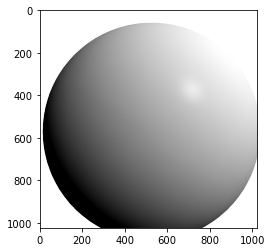

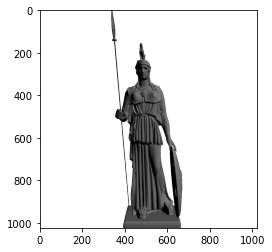

In [65]:
%matplotlib inline
plt.imshow(image_sphere.squeeze())
plt.grid(False)

plt.figure()
plt.imshow(image_model.squeeze())
plt.grid(False)

## Объявление параметров оптимизации

In [54]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [55]:
Niter = 3000
plot_period = 50

w_chamfer = 1.0 
w_edge = 1.0 
w_normal = 0.005 
w_laplacian = 0.1

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

In [56]:
loop = tqdm(range(Niter))


fig = plt.figure()
camera = Camera(fig)

for i in loop:
    optimizer.zero_grad()

    new_src_mesh = sphere_mesh.offset_verts(deform_verts)

    sample_trg = sample_points_from_meshes(model_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    loss_edge = mesh_edge_loss(new_src_mesh)
    loss_normal = mesh_normal_consistency(new_src_mesh)
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    loop.set_description('total_loss = %.6f' % loss)

    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)


    if i % plot_period == 0 or i==0:
        image_model = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_model = image_model.detach().cpu().numpy()
        plt.grid(False)
        plt.imsave(f'./gif_pics/{i//plot_period}.png', (image_model.squeeze()*255).astype(np.uint8))

    loss.backward()
    optimizer.step()

  0%|          | 0/3000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

## Выведем изображение полученной модели

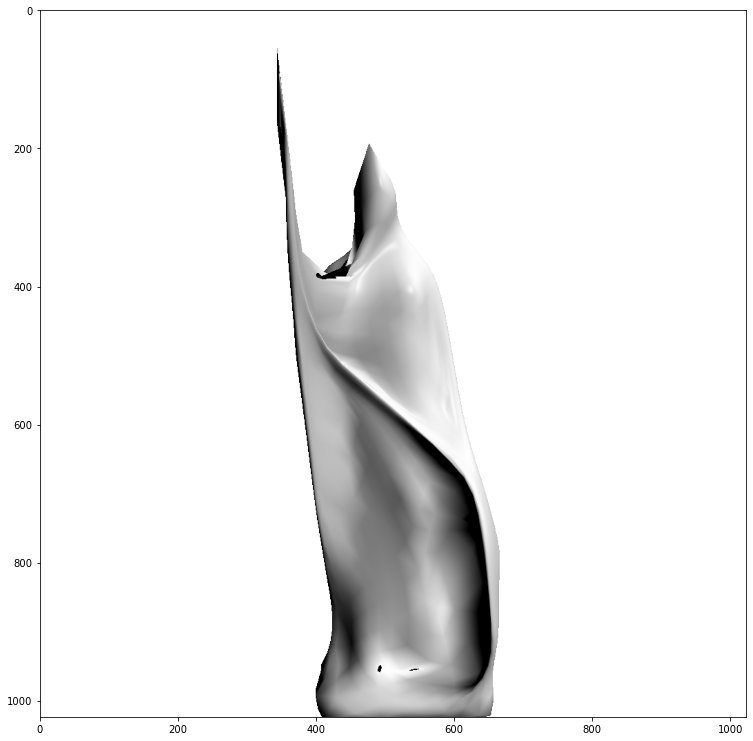

In [57]:
image_model = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
image_model = image_model.detach().cpu().numpy()
plt.figure(figsize=(13, 13))
plt.grid(False)
plt.imshow((image_model.squeeze()*255).astype(np.uint8))

## Функции ошибок

Text(0.5, 1.0, 'Loss vs iterations')

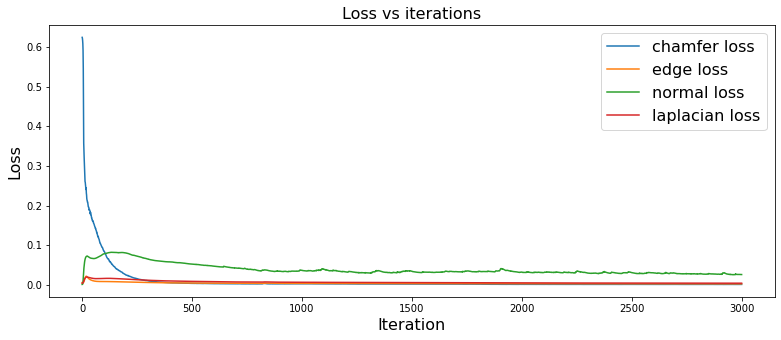

In [58]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")

## Сгенерируем GIF при помощи сохраненных изображений

In [40]:
frames = []
for frame_number in range(0, 59):
    frame = Image.open(f'./gif_pics/{frame_number}.png')
    frames.append(frame)
 
frames[0].save(
    './pictures/sphere2model.gif',
    save_all=True,
    append_images=frames[1:],
    optimize=True,
    duration=100,
    loop=0
)